<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.shape

(1460, 81)

In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
#Show statistics of sale price
house.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/Users/yujihoshi/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


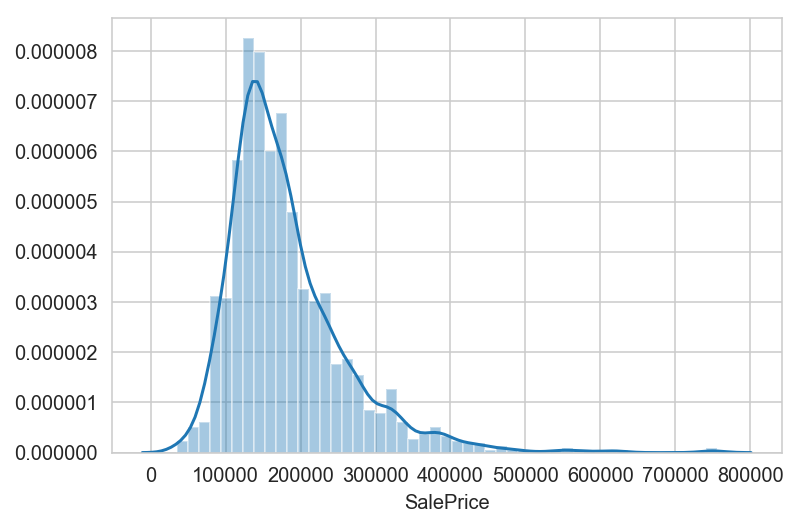

In [8]:
#Show distribution of sale price
sns.distplot(house['SalePrice'])
plt.show()

    MSSubClass
    20    1-STORY 1946 & NEWER ALL STYLES
    30    1-STORY 1945 & OLDER
    40    1-STORY W/FINISHED ATTIC ALL AGES
    45    1-1/2 STORY - UNFINISHED ALL AGES
    50    1-1/2 STORY FINISHED ALL AGES
    60    2-STORY 1946 & NEWER
    70    2-STORY 1945 & OLDER
    75    2-1/2 STORY ALL AGES
    80    SPLIT OR MULTI-LEVEL
    85    SPLIT FOYER
    90    DUPLEX - ALL STYLES AND AGES
    120    1-STORY PUD (Planned Unit Development) - 1946 & NEWER
    150    1-1/2 STORY PUD - ALL AGES
    160    2-STORY PUD - 1946 & NEWER
    180    PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
    190    2 FAMILY CONVERSION - ALL STYLES AND AGES

In [9]:
#Convert Housing category from integer to string
house['MSSubClass'] = house['MSSubClass'].astype(str)
house['MSSubClass'].value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [10]:
#What columns correlate most with the price?
corr = house.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [11]:
#Drop Id Column
house = house.drop('Id', axis = 1, errors='ignore')
#house.loc[:,'Id']=1
#house.Id

In [12]:
#What features can be changed?
#"Quality" metrics, such as kitchen quality
renovate_col = [col for col in house.columns if 'Qu' in col]

#"Condition" metrics, such as condition of garage
renovate_col.extend(['OverallCond', 'ExterCond', 'BsmtCond', 'GarageCond'])

#Heating and electrical components
renovate_col.extend(['Heating', 'HeatingQC', 'CentralAir', 'Electrical'])

#Roof and exterior features
renovate_col.extend(['RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea', 'Functional'])

# All changable features
renovate_col

renovate_col = house[renovate_col].columns
renovate_col

Index(['OverallQual', 'ExterQual', 'BsmtQual', 'LowQualFinSF', 'KitchenQual',
       'FireplaceQu', 'GarageQual', 'OverallCond', 'ExterCond', 'BsmtCond',
       'GarageCond', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'Functional'],
      dtype='object')

In [13]:
#Get column names of fixed features
fix_col = house.drop(renovate_col, axis=1).columns
fix_col = fix_col[1:-3]
fix_col

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
       'YearRemodAdd', 'Foundation', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [14]:
#Count how mnay missing values
missing = house.isnull().sum().sort_values(ascending=False)
missing.head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

In [15]:
#See which columns have NaN
missing_col = house.columns[house.isna().any()].tolist()
missing_col
house[missing_col].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
LotFrontage     1201 non-null float64
Alley           91 non-null object
MasVnrType      1452 non-null object
MasVnrArea      1452 non-null float64
BsmtQual        1423 non-null object
BsmtCond        1423 non-null object
BsmtExposure    1422 non-null object
BsmtFinType1    1423 non-null object
BsmtFinType2    1422 non-null object
Electrical      1459 non-null object
FireplaceQu     770 non-null object
GarageType      1379 non-null object
GarageYrBlt     1379 non-null float64
GarageFinish    1379 non-null object
GarageQual      1379 non-null object
GarageCond      1379 non-null object
PoolQC          7 non-null object
Fence           281 non-null object
MiscFeature     54 non-null object
dtypes: float64(3), object(16)
memory usage: 216.8+ KB


In [16]:
#Putting in numerical values for LotFrontage, MasVnrArea, GarageYrBlt

In [17]:
corr['LotFrontage'].sort_values(ascending=False).head()

LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
Name: LotFrontage, dtype: float64

In [18]:
corr['MasVnrArea'].sort_values(ascending=False).head()

MasVnrArea     1.000000
SalePrice      0.477493
OverallQual    0.411876
GrLivArea      0.390857
GarageArea     0.373066
Name: MasVnrArea, dtype: float64

In [19]:
corr['GarageYrBlt'].sort_values(ascending=False).head()

GarageYrBlt     1.000000
YearBuilt       0.825667
YearRemodAdd    0.642277
GarageCars      0.588920
GarageArea      0.564567
Name: GarageYrBlt, dtype: float64

In [20]:
#Impute NaN with estimated values
house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace=True)
house['MasVnrArea'].fillna(house['MasVnrArea'].median(), inplace=True)
house['GarageYrBlt'].fillna(house['YearBuilt'], inplace=True)

In [21]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Replace NA for NAN for string columns

In [22]:
#get column names with NaN in string columns
missing_string_col = house.columns[house.isna().any()].tolist()
missing_string_col

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [23]:
house.fillna(value = 'NA', inplace=True)

In [24]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


Perform any cleaning, feature engineering, and EDA you deem necessary.
Be sure to remove any houses that are not residential from the dataset.
Identify fixed features that can predict price.
Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
Characterize your model. How well does it perform? What are the best estimates of price?

In [25]:
#create model using only fixed characteristics to predict sale price
X = house[fix_col]
y = house['SalePrice']

In [26]:
X.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt',
       'YearRemodAdd', 'Foundation', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 54 columns):
MSZoning         1460 non-null object
LotFrontage      1460 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
Foundation       1460 non-null object
BsmtExposure     1460 non-null object
BsmtFinType1     1460 non-null object
BsmtFinSF1       1460 non-null int64
BsmtFinType2     1460 non-null object
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 n

In [28]:
objects = [key for key in dict(X.dtypes) if dict(X.dtypes)[key] in ['object']]

In [29]:
objects

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'Foundation',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'GarageType',
 'GarageFinish',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [30]:
#Dummies
dummies = pd.get_dummies(house[objects], drop_first = True)
# Merge the DataFrame result back onto the original DataFrame.

X = X.merge(dummies, left_index = True, right_index = True,how = 'outer')
X = X.drop(objects, axis = 1, errors='ignore')
print(X.shape)
X.head()

(1460, 144)


,LotFrontage,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,PoolQC_Gd,PoolQC_NA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,65.0,8450,2003,2003,706,0,150,856,856,854,...,0,1,0,0,0,1,1,0,0,0
1,80.0,9600,1976,1976,978,0,284,1262,1262,0,...,0,1,0,0,0,1,1,0,0,0
2,68.0,11250,2001,2002,486,0,434,920,920,866,...,0,1,0,0,0,1,1,0,0,0
3,60.0,9550,1915,1970,216,0,540,756,961,756,...,0,1,0,0,0,1,1,0,0,0
4,84.0,14260,2000,2000,655,0,490,1145,1145,1053,...,0,1,0,0,0,1,1,0,0,0


In [31]:
#Check if anything else is NAN
X.isnull().sum()[X.isnull().sum()>0]

Series([], dtype: int64)

In [32]:
X.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,PoolQC_Gd,PoolQC_NA,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,MiscFeature_NA,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,65.0,8450,2003,2003,706,0,150,856,856,854,...,0,1,0,0,0,1,1,0,0,0
1,80.0,9600,1976,1976,978,0,284,1262,1262,0,...,0,1,0,0,0,1,1,0,0,0
2,68.0,11250,2001,2002,486,0,434,920,920,866,...,0,1,0,0,0,1,1,0,0,0
3,60.0,9550,1915,1970,216,0,540,756,961,756,...,0,1,0,0,0,1,1,0,0,0
4,84.0,14260,2000,2000,655,0,490,1145,1145,1053,...,0,1,0,0,0,1,1,0,0,0


In [33]:
#Train Test Split
X_train = X[X['YrSold'] < 2010]
y_train = y[X['YrSold'] < 2010]
X_test = X[X['YrSold'] >= 2010]
y_test = y[X['YrSold'] >= 2010]

In [34]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [35]:
#Training Data and Test Data Score. 7 Folds had best results for test data for linear regression.
for i in [7]:
    result = []
    test = []
    kf = KFold(n_splits= i, shuffle= True, random_state= 42)
    kf.split(X_train)
    for train_index, test_index in kf.split(X_train):
        X_train2, X_test2 = X_train.values[train_index], X_train.values[test_index]
        Y_train2, Y_test2 = y_train.values[train_index], y_train.values[test_index]
        lr = LinearRegression()
        model = lr.fit(X_train2, Y_train2)
        #result.append(model.score(X_test2, Y_test2))
        test.append(model.score(X_test, y_test))
    #print(f'\nTraining {i} fold: \nlist = {result} \nmean = {np.mean(result)}\nstd = {np.std(result)}')
    print(f'\nTest {i} fold: \nlist = {test} \nmean = {np.mean(test)}\nstd = {np.std(test)}')


Test 7 fold: 
list = [0.8790786633068959, 0.8809396007034731, 0.8768863854363678, 0.8807888547087915, 0.8846690473404322, 0.8837089159886222, 0.8741849485136008] 
mean = 0.8800366308568833
std = 0.003410280468484075


In [36]:
#Column of price prediction using fixed columns
price_fixed = lr.predict(X)
price_fixed = pd.DataFrame(price_fixed, columns = ['price_fixed'])

In [37]:
#Get the coefficient values of the linear model
coefficients = []
for col, coef in zip(X, model.coef_):
    x = (col, coef)
    coefficients.append(x)
coefficients = pd.DataFrame(coefficients)

In [38]:
#Top 10 worst categorial features
coefficients.sort_values(1)[:10]

,0,1
134,PoolQC_Gd,-380815.674284
133,PoolQC_Fa,-338441.394081
86,Condition2_PosN,-166955.687805
119,BsmtFinType2_NA,-65403.070084
50,LandSlope_Sev,-53443.248014
92,BldgType_Twnhs,-43251.832094
93,BldgType_TwnhsE,-34149.010333
44,Utilities_NoSeWa,-30172.312617
47,LotConfig_FR3,-28993.017302
87,Condition2_RRAe,-28829.042678


In [39]:
#Top 10 best categorial features
coefficients.sort_values(1)[-10:].sort_values(1,ascending=False)

,0,1
135,PoolQC_NA,1.032942e+06
113,BsmtFinType1_NA,8.369726e+04
85,Condition2_PosA,8.268441e+04
72,Neighborhood_StoneBr,6.883411e+04
66,Neighborhood_NridgHt,6.284301e+04
65,Neighborhood_NoRidge,4.877840e+04
123,GarageType_Basment,3.472712e+04
126,GarageType_Detchd,3.462679e+04
124,GarageType_BuiltIn,3.328939e+04
32,MSZoning_RH,3.138557e+04


In [40]:
#Value of each area in square feet
coefficients[(coefficients[0].str.contains('SF'))&\
             ~(coefficients[0].str.contains('Foyer'))|\
             (coefficients[0].str.contains('Area'))|\
             (coefficients[0].str.contains('Porch'))].sort_values(1,ascending=False)

,0,1
27,PoolArea,2148.301928
9,2ndFlrSF,57.767454
26,ScreenPorch,52.379968
25,3SsnPorch,40.441929
8,1stFlrSF,34.781250
7,TotalBsmtSF,24.739301
21,GarageArea,20.355607
4,BsmtFinSF1,14.007310
22,WoodDeckSF,11.415924
10,GrLivArea,8.269444


In [41]:
#Value of basement related features
#When basement doesn't exist, seems like the coefficients negate eachother.
coefficients[coefficients[0].str.contains('Bsmt')].sort_values(1,ascending=False)

,0,1
113,BsmtFinType1_NA,83697.257076
117,BsmtFinType2_GLQ,23549.190867
106,BsmtExposure_Gd,22458.657661
111,BsmtFinType1_GLQ,6674.460708
11,BsmtFullBath,1739.217409
12,BsmtHalfBath,1671.411995
7,TotalBsmtSF,24.739301
4,BsmtFinSF1,14.007310
6,BsmtUnfSF,6.095813
5,BsmtFinSF2,4.636198


In [42]:
#Value of pool related features. 
#To break even with a pool, it must be at least 1340000/2150 = 625 sq ft
coefficients[coefficients[0].str.contains('Pool')].sort_values(1,ascending=False)

,0,1
135,PoolQC_NA,1.032942e+06
27,PoolArea,2.148302e+03
133,PoolQC_Fa,-3.384414e+05
134,PoolQC_Gd,-3.808157e+05


In [43]:
#Generally Pools are smaller than 625 sq ft, so this would devalue the home.
#As there are only 7 samples, it doesnt seem that useful though.
house[house.PoolArea > 0]['PoolArea'].describe()

count      7.000000
mean     575.428571
std       89.840335
min      480.000000
25%      515.500000
50%      555.000000
75%      612.000000
max      738.000000
Name: PoolArea, dtype: float64

In [44]:
#Value of Garage related features.
coefficients[coefficients[0].str.contains('Garage')].sort_values(1,ascending=False)

,0,1
123,GarageType_Basment,34727.116340
126,GarageType_Detchd,34626.791561
124,GarageType_BuiltIn,33289.392945
122,GarageType_Attchd,30651.818597
125,GarageType_CarPort,17172.066430
128,GarageFinish_NA,16076.828316
127,GarageType_NA,16076.828316
20,GarageCars,5244.976192
21,GarageArea,20.355607
19,GarageYrBlt,-57.096592


In [45]:
#Value of Type of Residential Zones, relative to Commercial Zone
coefficients[coefficients[0].str.contains('MSZoning')].sort_values(1,ascending=False)

,0,1
32,MSZoning_RH,31385.574493
31,MSZoning_FV,30474.921866
34,MSZoning_RM,26332.461396
33,MSZoning_RL,23156.862279


In [46]:
#Value of Neighborhoods
coefficients[coefficients[0].str.contains('Neighborhood')].sort_values(1,ascending=False)

,0,1
72,Neighborhood_StoneBr,68834.114341
66,Neighborhood_NridgHt,62843.006413
65,Neighborhood_NoRidge,48778.402222
74,Neighborhood_Veenker,27935.142222
63,Neighborhood_NPkVill,25495.393722
71,Neighborhood_Somerst,25326.729609
52,Neighborhood_BrDale,18909.935123
56,Neighborhood_Crawfor,15520.186237
70,Neighborhood_SawyerW,-376.394290
60,Neighborhood_MeadowV,-656.115721


Characterize your model. How well does it perform? What are the best estimates of price?

Performs very well with an R2 score of 88%

The best estimators in price is the neighborhood, garage features, and pool features. 


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

1. Evaluate the effect in dollars of the renovate-able features. Some examples of things that ARE renovate-able:

Roof and exterior features

"Quality" metrics, such as kitchen quality

"Condition" metrics, such as condition of garage

Heating and electrical components

In [47]:
#Looking at renovatable features
renovate_col

Index(['OverallQual', 'ExterQual', 'BsmtQual', 'LowQualFinSF', 'KitchenQual',
       'FireplaceQu', 'GarageQual', 'OverallCond', 'ExterCond', 'BsmtCond',
       'GarageCond', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'Functional'],
      dtype='object')

In [48]:
#Repeat previous steps but with all columns this time.
#create model using only with fixed and renovatable characteristics to predict sale price
X = house.drop(columns = ['SalePrice'], axis = 1)
y = house['SalePrice']

objects = [key for key in dict(X.dtypes) if dict(X.dtypes)[key] in ['object']]
#Dummies
dummies = pd.get_dummies(house[objects], drop_first = True)
# Merge the DataFrame result back onto the original DataFrame.

X = X.merge(dummies, left_index = True, right_index = True,how = 'outer')
X = X.drop(objects, axis = 1, errors='ignore')
print(X.shape)
X.head()

(1460, 274)


,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,0,1,0,0,0,1,0


In [49]:
#Train Test Split
X_train = X[X['YrSold'] < 2010]
y_train = y[X['YrSold'] < 2010]
X_test = X[X['YrSold'] >= 2010]
y_test = y[X['YrSold'] >= 2010]

In [50]:
#Training Data and Test Data Score. 10 Folds had best results for test data for linear regression.
for i in [10]:
    result = []
    test = []
    kf = KFold(n_splits= i, shuffle= True, random_state= 42)
    kf.split(X_train)
    for train_index, test_index in kf.split(X_train):
        X_train2, X_test2 = X_train.values[train_index], X_train.values[test_index]
        Y_train2, Y_test2 = y_train.values[train_index], y_train.values[test_index]
        lr = LinearRegression()
        model = lr.fit(X_train2, Y_train2)
        #result.append(model.score(X_test2, Y_test2))
        test.append(model.score(X_test, y_test))
    #print(f'\nTraining {i} fold: \nlist = {result} \nmean = {np.mean(result)}\nstd = {np.std(result)}')
    print(f'\nTest {i} fold: \nlist = {test} \nmean = {np.mean(test)}\nstd = {np.std(test)}')


Test 10 fold: 
list = [0.9052488381872283, 0.9065751473554823, 0.9099557564865379, 0.8968775138781259, 0.9034217537921233, 0.9068160400977033, 0.9094578228830824, 0.9084211822099986, 0.905628113640925, 0.8916631928946562] 
mean = 0.9044065361425864
std = 0.005524362452802992


In [51]:
#Column of price prediction using all columns
price_all = lr.predict(X)
price_all = pd.DataFrame(price_all, columns = ['price_all'])

In [52]:
#Get the coefficient values of the linear model
coefficients = []
for col, coef in zip(X, model.coef_):
    x = (col, coef)
    coefficients.append(x)
coefficients = pd.DataFrame(coefficients)

In [53]:
#Top 10 worst categorial features
coefficients.sort_values(1)[:10].sort_values(1,ascending=True)

,0,1
104,Condition2_PosN,-243458.529170
250,PoolQC_Fa,-160947.205572
241,GarageQual_Po,-152345.393891
238,GarageQual_Fa,-150216.890858
239,GarageQual_Gd,-147438.678089
242,GarageQual_TA,-144600.058454
251,PoolQC_Gd,-131629.962783
212,Electrical_Mix,-79648.610953
68,LandSlope_Sev,-76094.949664
62,Utilities_NoSeWa,-61334.757877


In [54]:
#Top 10 best categorial features
coefficients.sort_values(1)[-10:].sort_values(1,ascending=False)

,0,1
125,RoofMatl_Membran,645215.859853
130,RoofMatl_WdShngl,615955.480871
124,RoofMatl_CompShg,561774.331668
129,RoofMatl_WdShake,557377.194348
128,RoofMatl_Tar&Grv,530097.919704
252,PoolQC_NA,204526.044558
246,GarageCond_Po,145828.861596
244,GarageCond_Gd,137197.832573
243,GarageCond_Fa,135968.841042
247,GarageCond_TA,135619.202172


In [55]:
coefficients[coefficients[0].str.contains('RoofMatl')].sort_values(1,ascending=False)

,0,1
125,RoofMatl_Membran,6.452159e+05
130,RoofMatl_WdShngl,6.159555e+05
124,RoofMatl_CompShg,5.617743e+05
129,RoofMatl_WdShake,5.573772e+05
128,RoofMatl_Tar&Grv,5.300979e+05
126,RoofMatl_Metal,1.935405e-09
127,RoofMatl_Roll,1.193257e-09


In [56]:
coefficients[coefficients[0].str.contains('RoofStyle')].sort_values(1,ascending=False)

,0,1
122,RoofStyle_Mansard,3263.398671
120,RoofStyle_Gambrel,-7566.270416
119,RoofStyle_Gable,-11696.473547
121,RoofStyle_Hip,-13299.546282
123,RoofStyle_Shed,-24514.326604


In [57]:
house[house.RoofStyle == 'Shed']['RoofMatl'].value_counts()

WdShake    1
CompShg    1
Name: RoofMatl, dtype: int64

In [58]:
coefficients[coefficients[0].str.contains('Heating')].sort_values(1,ascending=False)

,0,1
204,Heating_Wall,2.823864e+04
200,Heating_GasA,4.008950e+03
207,HeatingQC_Po,1.746230e-10
201,Heating_GasW,-2.736607e+03
205,HeatingQC_Fa,-3.449354e+03
208,HeatingQC_TA,-3.631178e+03
206,HeatingQC_Gd,-3.744661e+03
202,Heating_Grav,-6.755709e+03
203,Heating_OthW,-1.518490e+04


In [59]:
#It makes no sense that the same exterior features should have different values between Exterior1st and 2nd.
#Perhaps it'd be best combine them into one column as feature engineering.

coefficients[(coefficients[0].str.contains('Exterior1st'))|(coefficients[0].str.contains('Exterior2nd'))].sort_values(1,ascending=False)

,0,1
133,Exterior1st_BrkFace,1.785429e+04
140,Exterior1st_Stone,1.651456e+04
151,Exterior2nd_ImStucc,1.009703e+04
149,Exterior2nd_CmentBd,8.897840e+03
156,Exterior2nd_Stucco,7.572866e+03
138,Exterior1st_MetalSd,3.853429e+03
158,Exterior2nd_Wd Sdng,1.020900e+03
131,Exterior1st_AsphShn,-8.731149e-11
136,Exterior1st_HdBoard,-6.893385e+02
157,Exterior2nd_VinylSd,-2.744895e+03


In [60]:
coefficients[coefficients[0].str.contains('Functional')].sort_values(1,ascending=False)

,0,1
223,Functional_Typ,20212.635599
220,Functional_Min2,14449.497647
219,Functional_Min1,12768.206674
221,Functional_Mod,5534.114168
218,Functional_Maj2,-866.024191
222,Functional_Sev,-29589.362459


__Evaluate the effect in dollars of the renovate-able features.__

Looking at the differences in coefficient values, we can see the features that would bring in the biggest change in value would be the following:

-  Functional Rating: If we can get from Severe to Typical, we can raise the value by 50k. Major to Typical gets 20k. Moderate gets 13k, and Minimal gets 7k.
-  Exterior Material: Wd Shng, CBlck, HdBoard, and Plywood have negative values. BrkFace and CmentBd have high values. 10-15k
-  Roof Style: Shed, Hip, and Gable worst. Mansard Best. 10-15k (excluding Shed as outlier)
-  Roof Material: Anything but roll and metal. Also ClayTile. Improves 50-60k. Few Samples though.
-  Heating: Heating Wall and GasA are best. Others not so great. 10-20k
-  Garage Quality: Poor to TA gets about 6k.

__How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money.__

I would find the difference from the first model and second model for each property.
If the cost of renovation is less than the difference, then I would buy the property.

__Investigate how much of the variance in price remaining is explained by these features.__

-  Column 1: Actual Sale Price
-  Column 2: Predicted Sale Price using Fixed Columns
-  Column 3: Predicted Sale Price using all columns
-  Column 4: C2 - C3
-  Column 5: Fixed Residuals
-  Column 6: All Residiauls

If Column 9: (Fixed Pred - All Pred) is positive and large, then it's a possible candidate for renovation.

Get variance of Column 6 and Column 8 to compare

In [61]:
house2 = house['SalePrice']
reno_gain = pd.DataFrame((price_fixed.price_fixed-price_all.price_all), columns = ['reno_gain'])
fixed_res = pd.DataFrame((house['SalePrice'] - price_fixed.price_fixed), columns = ['fixed_res'])
all_res = pd.DataFrame((house['SalePrice'] - price_all.price_all), columns = ['all_res'])
house2 = pd.concat([house2, price_fixed, price_all, reno_gain, fixed_res, all_res], axis=1, join_axes=[house2.index])

In [62]:
# Properties with the highest renovation gains in value
house2[(house2.SalePrice<house2.price_fixed)&(house2.reno_gain>0)].sort_values('reno_gain',ascending=False).head(10)

,SalePrice,price_fixed,price_all,reno_gain,fixed_res,all_res
1298,160000,268451.149466,160000.000000,108451.149467,-108451.149466,3.219757e-07
1000,82000,97278.263347,9847.025218,87431.238129,-15278.263347,7.215297e+04
828,185000,202754.273197,116482.786843,86271.486354,-17754.273197,6.851721e+04
1423,274970,360496.352723,294142.441843,66353.910880,-85526.352723,-1.917244e+04
666,129000,187866.234135,129000.000000,58866.234135,-58866.234135,7.086783e-08
1031,197000,265120.957829,211234.009238,53886.948591,-68120.957829,-1.423401e+04
1048,115000,171527.195198,118297.252092,53229.943106,-56527.195198,-3.297252e+03
595,319000,372229.750656,319000.000000,53229.750656,-53229.750656,-4.027970e-08
1155,218000,266041.611380,214132.367843,51909.243536,-48041.611380,3.867632e+03
1068,151400,219531.298857,168957.751819,50573.547038,-68131.298857,-1.755775e+04


In [63]:
# The Variance has increased when using all the columns as shown by a higher mean in residuals.
house2[['fixed_res', 'all_res']].describe()

,fixed_res,all_res
count,1460.000000,1460.000000
mean,1028.151578,1564.949341
std,28360.780691,30936.397892
min,-160307.556273,-170706.272898
25%,-12933.763896,-9039.079178
50%,574.343254,460.025551
75%,13332.680057,9803.455754
max,235882.670143,641437.265289


__Do you trust your model? Should it be used to evaluate which properties to buy and fix up?__

Somewhat, but I would tweak the algorithm more so there are less conflicting data.
It's a start to a good model.

How to test? Try a few examples based on best candidates.
Index 1298 has the following renovatable features:

In [64]:
house.iloc[1298,:][renovate_col]

OverallQual          10
ExterQual            Ex
BsmtQual             Ex
LowQualFinSF          0
KitchenQual          Ex
FireplaceQu          Gd
GarageQual           TA
OverallCond           5
ExterCond            TA
BsmtCond             TA
GarageCond           TA
Heating            GasA
HeatingQC            Ex
CentralAir            Y
Electrical        SBrkr
RoofStyle           Hip
RoofMatl        ClyTile
Exterior1st      Stucco
Exterior2nd      Stucco
MasVnrType        Stone
MasVnrArea          796
Functional          Typ
Name: 1298, dtype: object

RoofStyle upgraded from Hip to Mansard, RoofMatl upgraded from ClayTile
10-15k + 50k so if model is correct, at least 60k profit.40-50k unrealised from being in very good quality?
Very undervalued to begin with at sale price so buyer bought at bargain.

If roofing upgrade created value as shown in model, then good to buy, but I have suspicions in model still inaccurate especially as this is the only property with ClayTile.

In [65]:
house.iloc[666,:][renovate_col]

OverallQual           6
ExterQual            TA
BsmtQual             Gd
LowQualFinSF          0
KitchenQual          TA
FireplaceQu          Po
GarageQual           TA
OverallCond           5
ExterCond            Gd
BsmtCond             TA
GarageCond           TA
Heating            GasA
HeatingQC            TA
CentralAir            Y
Electrical        SBrkr
RoofStyle          Flat
RoofMatl        Tar&Grv
Exterior1st     Plywood
Exterior2nd     Plywood
MasVnrType       BrkCmn
MasVnrArea          113
Functional          Sev
Name: 666, dtype: object

-  Upgrade Functional Rating from Severe to Typical. 50k.
-  Upgrade Exterior from Plywood to BrkFace or CmentBd. 10-15k
-  Overal Quality: Increase 6k per point


The model is good at filtering through to find undervalued properties. Model to be used as a guide and filter. Not as Rule.

#### Feature Engineering with more time
-  Dummies to combine Exterior1st and Exterior2nd.
-  Put in Sqft values of materials used for roof/ bsmt finish/Masonry veneer/ instead of binary classifications.
-  Quantify quality metrics to numerical values
-  Remove PoolQC currently bonkers and also affecting Pool sq ft price.
-  Remove categories with less than 5 properties to NA for categorial and non-quality/condition metric.
-  Imputing calculated values for LotFrontage, 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [67]:
# A: